In [6]:
import pandas as pd
from pandas_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tkinter
from sklearn.preprocessing import PowerTransformer,MinMaxScaler
from sklearn.svm import SVC
import xgboost
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics as metric
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
import pickle


In [7]:
#reading input file

df = pd.read_csv('CE802_P3_Data/CE802_P3_Data.csv')

<AxesSubplot: >

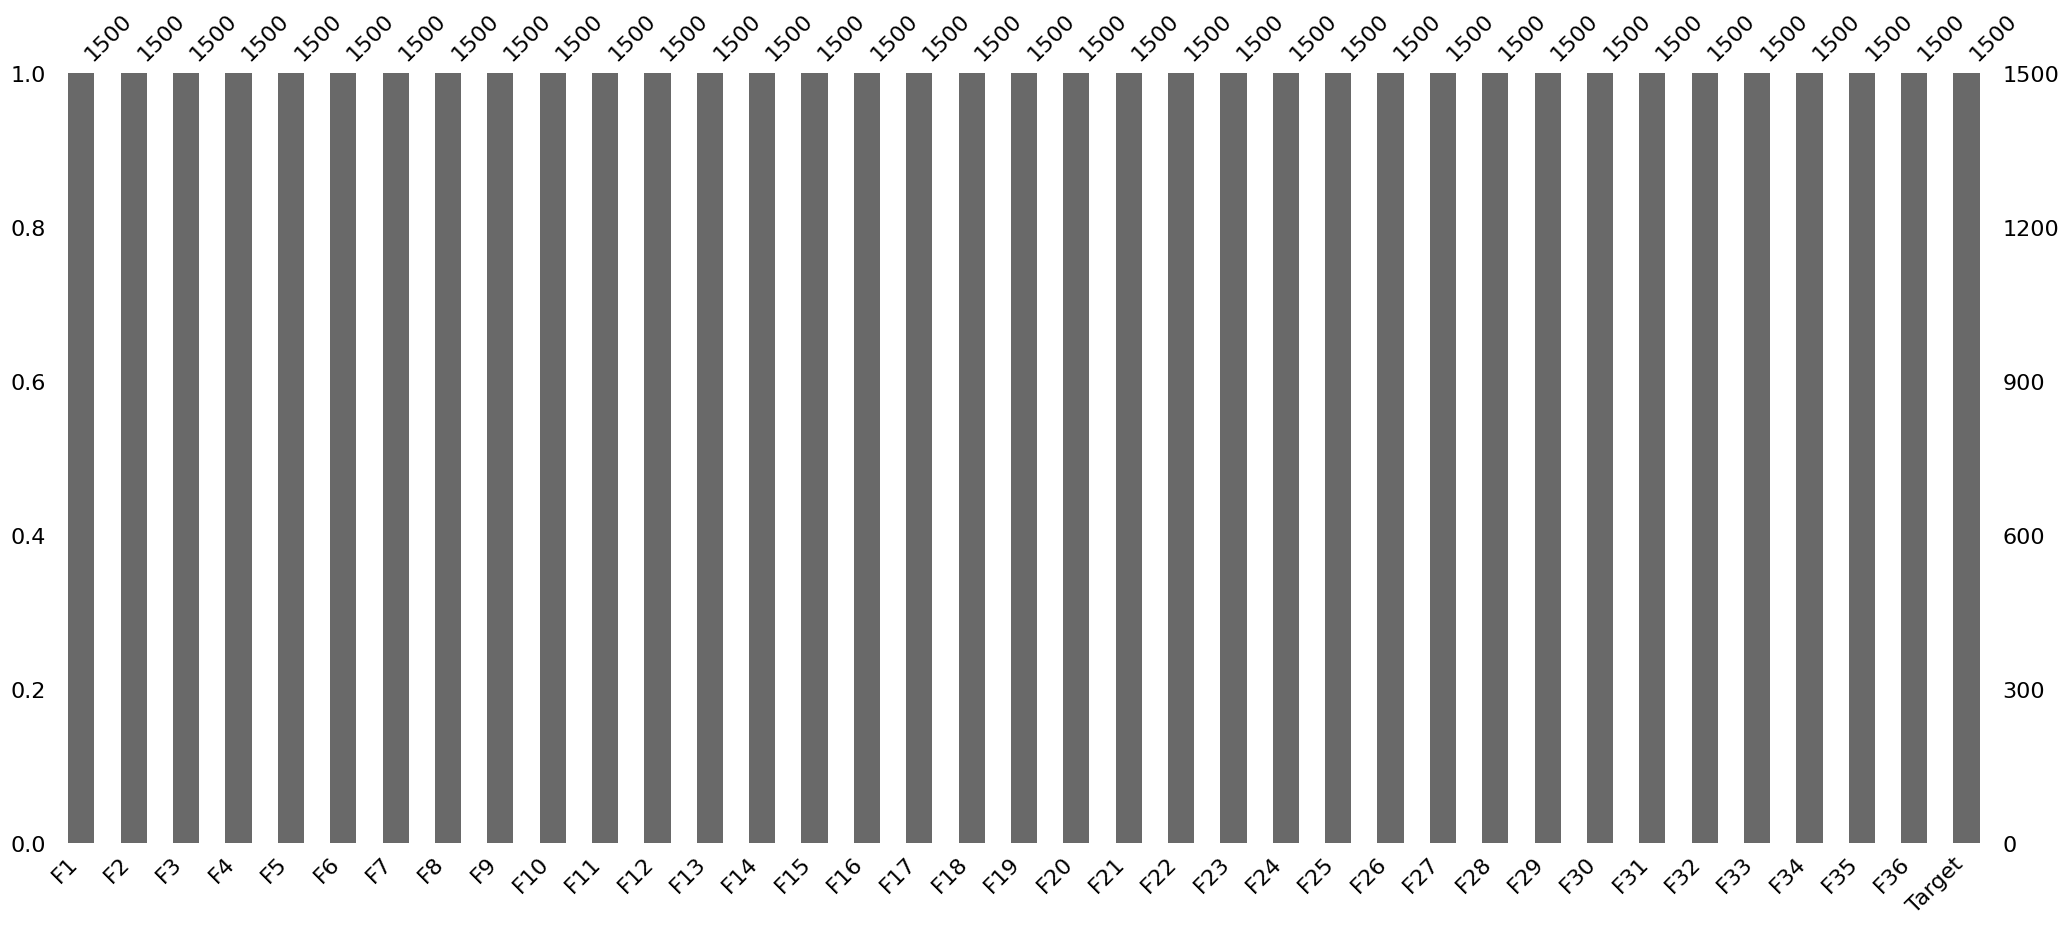

In [8]:
# checking for missing data
import missingno as msno
msno.bar(df)

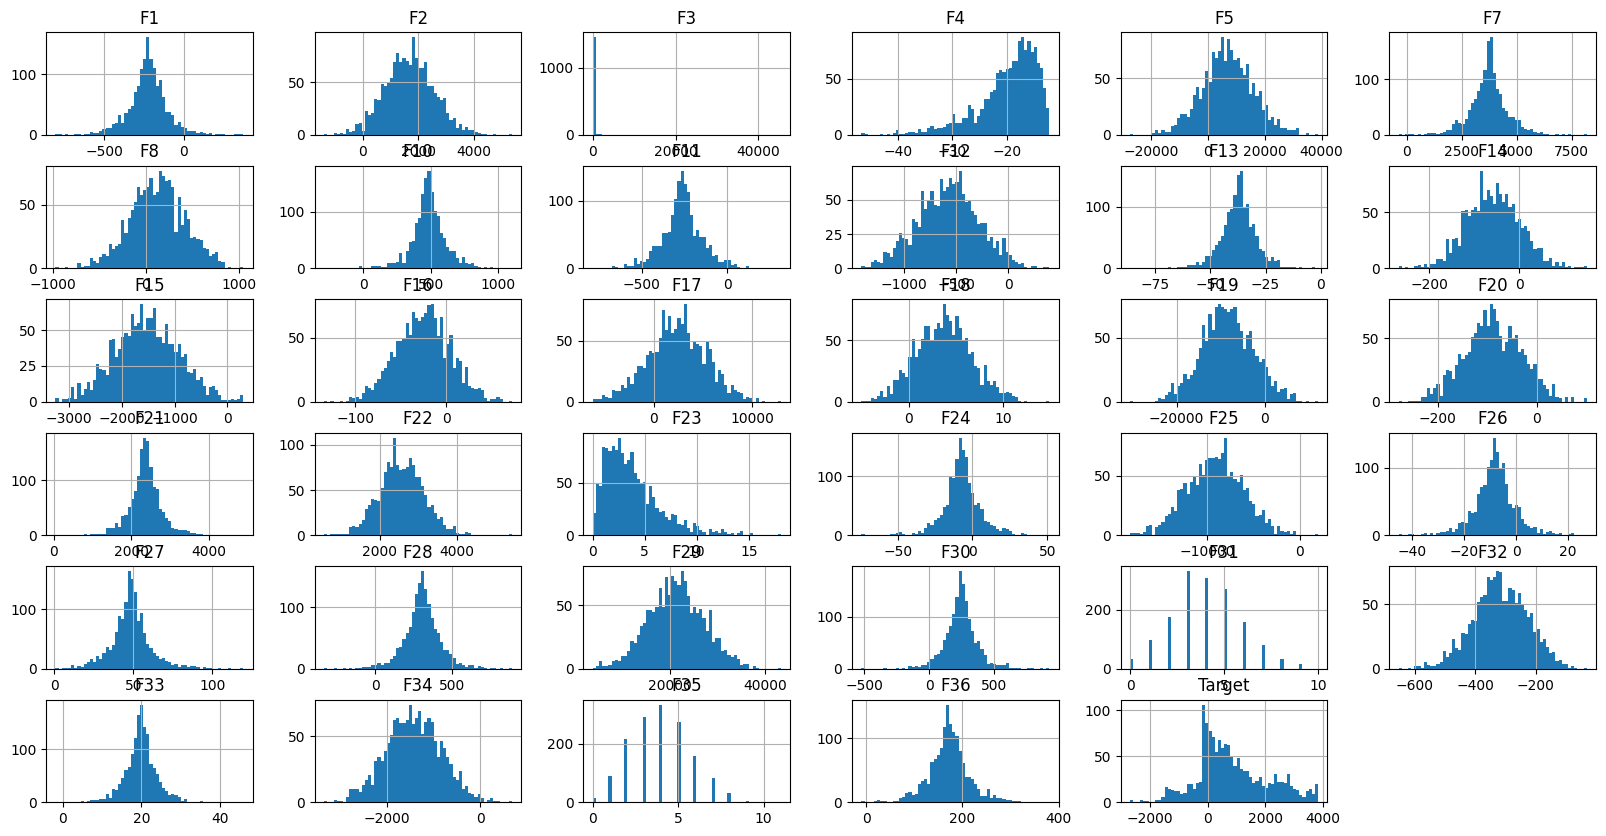

In [9]:
# checking data distribution
ax = df.hist(figsize=(20,10),bins=60)
plt.show()

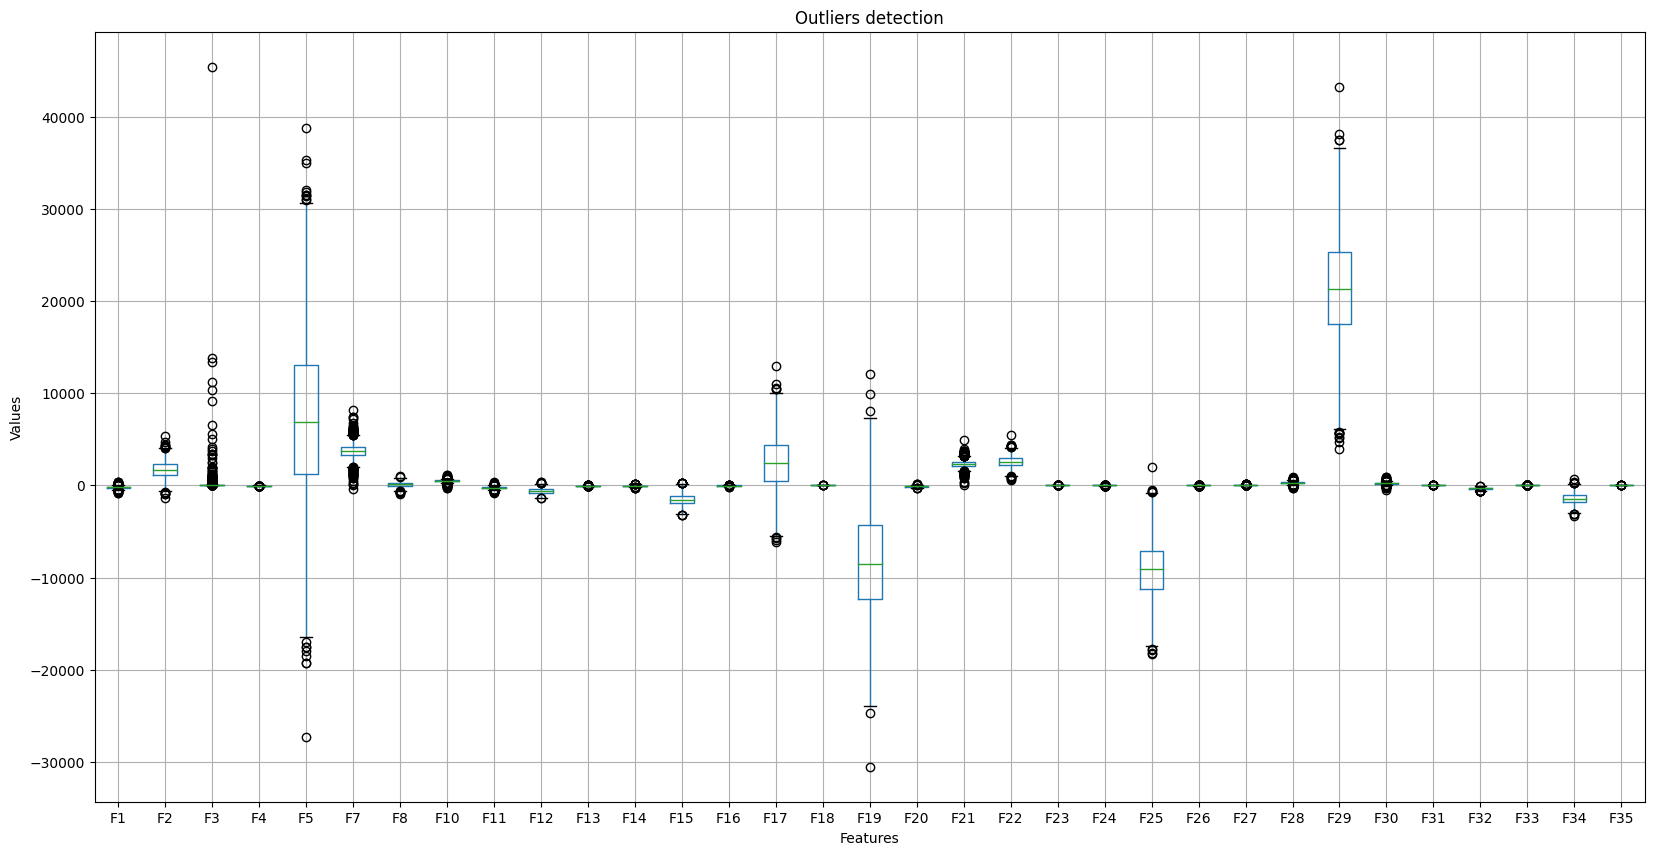

In [10]:
#checking for outliers
ax = df.iloc[:, 0:35].boxplot(figsize=(20,10))
ax.set_xlabel('Features')
ax.set_ylabel('Values')
ax.set_title('Outliers detection')
plt.savefig("plots/outliers.png")
# plt.show()

In [11]:
# checking uniqueness in data
df.nunique()

F1        1406
F2        1495
F3         737
F4         732
F5        1498
F6           4
F7        1494
F8        1492
F9           5
F10       1409
F11       1423
F12       1485
F13        910
F14       1402
F15       1492
F16       1382
F17       1499
F18        839
F19       1500
F20       1396
F21       1487
F22       1485
F23        723
F24        905
F25       1499
F26        911
F27        900
F28       1409
F29       1500
F30       1410
F31         11
F32       1412
F33        889
F34       1494
F35         12
F36       1421
Target    1497
dtype: int64

In [12]:
# checking for skewness in data
df.skew(skipna = True)

/var/folders/zj/hd8_xvbd3fvbp9wj5412cw_c0000gn/T/ipykernel_58302/2135450750.py:2: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.skew(skipna = True)


F1         0.053778
F2         0.092819
F3        24.348488
F4        -1.327711
F5         0.036062
F7        -0.035560
F8        -0.073244
F10       -0.301440
F11       -0.036346
F12        0.001582
F13       -0.072602
F14        0.072073
F15        0.066214
F16       -0.039172
F17       -0.026494
F18        0.092250
F19        0.069746
F20        0.011839
F21       -0.059387
F22        0.109312
F23        1.327012
F24       -0.309991
F25       -0.010501
F26       -0.061756
F27        0.481633
F28       -0.093281
F29        0.035187
F30        0.093222
F31        0.235196
F32       -0.138361
F33        0.058530
F34        0.038294
F35        0.264866
F36        0.078137
Target     0.438126
dtype: float64

In [13]:
pt = PowerTransformer(method='yeo-johnson')

#normalizing data using MinMaxScaling
scaleable_features = ['F1','F2','F5','F7','F8','F10','F11','F12','F13','F14','F15','F16','F17','F18','F19','F20','F21','F22','F24','F25','F26','F27','F28','F29','F30','F31','F32','F33','F34']
scale = MinMaxScaler()
df[scaleable_features] = scale.fit_transform(df[scaleable_features])


# transforming skewed data with PowerTransform

f3 = np.array(df['F3'])
f4 = np.array(df['F4'])
f23 = np.array(df['F23'])
reshaped_f3 = np.array(f3).reshape(-1, 1)
reshaped_f4 = np.array(f4).reshape(-1, 1)
reshaped_f23 = np.array(f23).reshape(-1, 1)

df['F3'] = pt.fit_transform(reshaped_f3)
df['F4'] = pt.fit_transform(reshaped_f4)
df['F23'] = pt.fit_transform(reshaped_f23)

In [14]:
# removing outliers

#function to remove outlires using IQR
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

df = remove_outlier(df, 'F36')
df = remove_outlier(df, 'F35')
df = remove_outlier(df, 'F23')


df = remove_outlier(df, 'F2')
df = remove_outlier(df, 'F1')

/var/folders/zj/hd8_xvbd3fvbp9wj5412cw_c0000gn/T/ipykernel_58302/3373179028.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat = df.corr()


<AxesSubplot: >

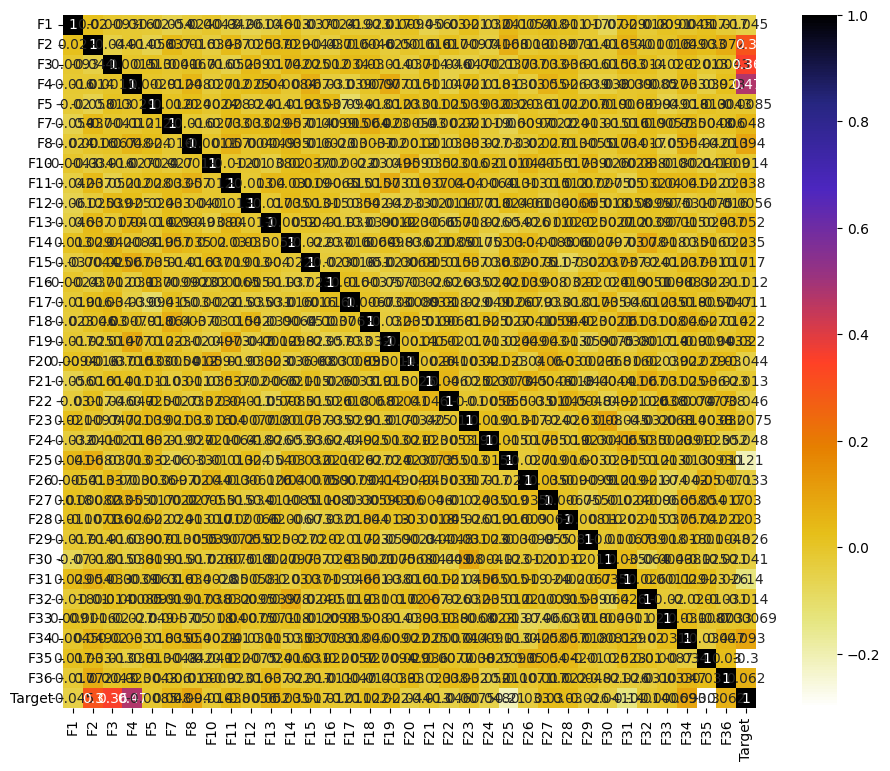

In [15]:
# checking for correlation

corrmat = df.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat,annot=True, square=True, cmap=plt.cm.CMRmap_r)

In [16]:
# mapping catagorical data
df['F6'] = df['F6'].map({'UK':1, 'Europe':2,'USA':3,'Rest':4})
df['F9'] = df['F9'].map({'Very high':1,'High':2,'Medium':3,'Low':4 , 'Very low':5})


In [17]:
# comparing multiple models
estimators = {
    'Ridge': linear_model.Ridge(),
    'BayesianRidge':linear_model.BayesianRidge(),
    'Lasso': linear_model.Lasso(),
    'LinearRegression': LinearRegression(),
    'xgboost':xgboost.XGBRegressor()

}
# seperating features and output
X = df.iloc[:, df.columns != 'Target']
y = df.iloc[:,  df.columns == 'Target']

# splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 50, test_size = 0.3)

# fitting models and checking their accuracy 
for name, estimator in estimators.items():
        print(name)
        estimator.fit(X_train, y_train)
        y_pred = estimator.predict(X_test)
        print(f'The accuracy score is: {estimator.score(X_test,y_test):.4f}')
        print(f'MSE : {metric.mean_squared_error(y_test, y_pred)}')
        print(f'R2 : {metric.r2_score(y_test, y_pred)}')
        print('#'*100)

Ridge
The accuracy score is: 0.7927
MSE : 320005.0480275465
R2 : 0.7926822507924594
####################################################################################################
BayesianRidge


/Users/deepaknandula/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The accuracy score is: 0.7926
MSE : 320206.8201369697
R2 : 0.79255153116839
####################################################################################################
Lasso
The accuracy score is: 0.7961
MSE : 314676.6730797073
R2 : 0.7961342797774046
####################################################################################################
LinearRegression
The accuracy score is: 0.7913
MSE : 322197.7011018673
R2 : 0.7912617235133959
####################################################################################################
xgboost
The accuracy score is: 0.7686
MSE : 357244.01973896817
R2 : 0.7685566945063891
####################################################################################################


Ridge
The accuracy score is: -0.0134
Rsme : 1773.4524076924338
####################################################################################################
BayesianRidge
The accuracy score is: 0.0117
Rsme : 1729.3790498538642
####################################################################################################
Lasso
The accuracy score is: -0.0132
Rsme : 1772.9441722987665
####################################################################################################
LinearRegression
The accuracy score is: -0.0134
Rsme : 1773.4574136341073
####################################################################################################
xgboost
The accuracy score is: -0.3546
Rsme : 2370.474907703844
####################################################################################################

In [18]:
# feature selection for the otimal models

estimators = {
    'Ridge': SelectFromModel(linear_model.Ridge(alpha=1.0)),
    'BayesianRidge':SelectFromModel(linear_model.BayesianRidge()),
    'Lasso': SelectFromModel(linear_model.Lasso(alpha=0.1)),
    'LinearRegression': SelectFromModel(LinearRegression())

}

# seperating features and output
X = df.iloc[:, df.columns != 'Target']
y = df.iloc[:,  df.columns == 'Target']

# splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 50, test_size = 0.3)

# fitting models and checking their accuracy 
for name, estimator in estimators.items():
        print(name)
        estimator.fit(X_train, y_train)
        # y_pred = estimator.predict(X_test)
        # print(f'The accuracy score is: {estimator.score(X_test,y_test):.4f}')
        # print(f'Rsme : {metric.mean_squared_error(y_test, y_pred)}')
        print(f'selected Features: {estimator.get_support()}')
        print(f'Features: ')
        print(X_train.columns[(estimator.get_support())])
        print('#'*100)

Ridge
selected Features: [False  True  True  True False False False  True False False  True False
 False False False False False False False False False False False False
  True False False False False False  True False False False False False]
Features: 
Index(['F2', 'F3', 'F4', 'F8', 'F11', 'F25', 'F31'], dtype='object')
####################################################################################################
BayesianRidge


/Users/deepaknandula/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


selected Features: [False  True  True  True False False False  True False False  True False
 False False False False False False False False False False False False
  True False False False False False  True False False False False False]
Features: 
Index(['F2', 'F3', 'F4', 'F8', 'F11', 'F25', 'F31'], dtype='object')
####################################################################################################
Lasso
selected Features: [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True]
Features: 
Index(['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11',
       'F12', 'F13', 'F14', 'F15', 'F16', 'F17', 'F18', 'F19', 'F20', 'F21',
       'F22', 'F23', 'F24', 'F25', 'F26', 'F27', 'F28', 'F29', 'F30', 'F31',
       'F32', 'F33', 'F34', 'F35', 'F36'],
      dtype='object')
##############################

In [19]:
# GridSearching model for hiper parameter tuning

estimators = {
    'Ridge': linear_model.Ridge(),
    'Lasso': linear_model.Lasso(),
    'LinearRegression': LinearRegression()

}

gridParams = {
    'Ridge': {'alpha':  [1e-5,0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 
                    10.0, 20, 50, 100, 500, 1000 ]},
    'Lasso': {'alpha': [1e-5,0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 
                    10.0, 20, 50, 100, 500, 1000 ]},
    'LinearRegression' : {'fit_intercept':[True,False], 'copy_X':[True, False]}
}



# seperating features and output
X = df.iloc[:, df.columns != 'Target']
y = df.iloc[:,  df.columns == 'Target']

# splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 50, test_size = 0.3)

# fitting models and checking their accuracy 
for name, estimator in estimators.items():
        print(name)
        clf = GridSearchCV(estimator,gridParams[name])
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(f'The accuracy score is: {clf.score(X_test,y_test):.4f}')
        print(f'Rsme : {metric.mean_squared_error(y_test, y_pred)}')
        print(f'Optimal parameters : {clf.best_params_}')
        print('#'*100)

Ridge
The accuracy score is: 0.7924
Rsme : 320370.9599096051
Optimal parameters : {'alpha': 0.7}
####################################################################################################
Lasso
The accuracy score is: 0.7982
Rsme : 311497.37981083704
Optimal parameters : {'alpha': 2.0}
####################################################################################################
LinearRegression
The accuracy score is: 0.7913
Rsme : 322197.7011018673
Optimal parameters : {'copy_X': True, 'fit_intercept': True}
####################################################################################################


In [20]:
#Training optimal model with best obtained parameters
reg = linear_model.Lasso(alpha=2.0)

reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print(f'The accuracy score is: {reg.score(X_test,y_test):.4f}')
print(f'Rsme : {metric.mean_squared_error(y_test, y_pred)}')
print('#'*100)
# pickle.dump(reg, open('prob2lasso', "wb"))

The accuracy score is: 0.7982
Rsme : 311497.37981083704
####################################################################################################


In [21]:
# HERE YOU WILL USE THIS TEMPLATE TO SAVE THE PREDICTIONS ON THE TEST SET

# Load the test data
test_df = pd.read_csv('CE802_P3_Test.csv')

# Make sure you work on a copy
test_data = test_df.iloc[:,:-1].copy()


pt = PowerTransformer(method='yeo-johnson')

scaleable_features = ['F1','F2','F5','F7','F8','F10','F11','F12','F13','F14','F15','F16','F17','F18','F19','F20','F21','F22','F24','F25','F26','F27','F28','F29','F30','F31','F32','F33','F34']


scale = MinMaxScaler()

test_data[scaleable_features] = scale.fit_transform(test_data[scaleable_features])

f3 = np.array(test_data['F3'])
f4 = np.array(test_data['F4'])
f23 = np.array(test_data['F23'])
reshaped_f3 = np.array(f3).reshape(-1, 1)
reshaped_f4 = np.array(f4).reshape(-1, 1)
reshaped_f23 = np.array(f23).reshape(-1, 1)

test_data['F3'] = pt.fit_transform(reshaped_f3)
test_data['F4'] = pt.fit_transform(reshaped_f4)
test_data['F23'] = pt.fit_transform(reshaped_f23)

test_data['F6'] = test_data['F6'].map({'UK':1, 'Europe':2,'USA':3,'Rest':4})
test_data['F9'] = test_data['F9'].map({'Very high':1,'High':2,'Medium':3,'Low':4 , 'Very low':5})

# reg = pickle.load(open('prob2lasso', "rb"))

predicted = reg.predict(test_data)
... # CHANGE HERE -- use your previously trained predictor and apply it to test_data
                # (test_data can be modified if needed but make sure you don't change the order of the rows)...

# Replace the last (empty) column with your prediction
test_df.iloc[:,-1] = predicted

# Save to the destination file
test_df.to_csv('CE802_P3_Test_Predictions.csv', index=False, float_format='%.8g')

# IMPORTANT!! Make sure only the last column has changed
assert pd.read_csv('CE802_P3_Test.csv').iloc[:,:-1].equals(pd.read_csv('CE802_P3_Test_Predictions.csv').iloc[:,:-1])